# Notebook with training BNN on synthetic data

## Synthetic data

In [1]:
!pip install pyro-ppl gpflow

In [0]:
import numpy as np
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import pyro
from pyro.distributions import Normal, Categorical
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import Adam
import matplotlib.pyplot as plt
import random
import gpflow
import tensorflow as tf
from api.data_sampling import (gaussian_sampler_2d, 
                               gaussian_data_sampling,
                               gaussian_mixture_data_sampling,
                               plot_2d_data,
                               plot_1d_label_data,
                               plot_variance_and_mean)

## Constants

In [0]:
num_hidden_neurons = 50
sigma_b = 1.0
mean = 0.0
sigma_w = [4.0, 3.0, 2.25, 2.0, 2.0, 1.9, 1.75, 1.75, 1.7, 1.65]
sigma_likelihood = 0.1

## Example of training BNNs

In [0]:
class NN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(NN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)
        
    def forward(self, x):
        output = self.fc1(x)
        output = F.relu(output)
        output = self.out(output)
        return output

train_loader = torch.utils.data.DataLoader(
        datasets.MNIST('mnist-data/', train=True, download=True,
                       transform=transforms.Compose([transforms.ToTensor(),])),
        batch_size=128, shuffle=True)

test_loader = torch.utils.data.DataLoader(
        datasets.MNIST('mnist-data/', train=False, transform=transforms.Compose([transforms.ToTensor(),])
                       ),
        batch_size=128, shuffle=True)

net = NN(28*28, 1024, 10)

Extracting mnist-data/MNIST/raw/train-images-idx3-ubyte.gz


Extracting mnist-data/MNIST/raw/train-labels-idx1-ubyte.gz


Extracting mnist-data/MNIST/raw/t10k-images-idx3-ubyte.gz


Extracting mnist-data/MNIST/raw/t10k-labels-idx1-ubyte.gz
Processing...


../torch/csrc/utils/tensor_numpy.cpp:135: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


Done!


In [0]:
log_softmax = nn.LogSoftmax(dim=1)

def model(x_data, y_data):
    
    fc1w_prior = Normal(loc=torch.zeros_like(net.fc1.weight), scale=torch.ones_like(net.fc1.weight))
    fc1b_prior = Normal(loc=torch.zeros_like(net.fc1.bias), scale=torch.ones_like(net.fc1.bias))
    
    outw_prior = Normal(loc=torch.zeros_like(net.out.weight), scale=torch.ones_like(net.out.weight))
    outb_prior = Normal(loc=torch.zeros_like(net.out.bias), scale=torch.ones_like(net.out.bias))
    
    priors = {'fc1.weight': fc1w_prior, 'fc1.bias': fc1b_prior,  
              'out.weight': outw_prior, 'out.bias': outb_prior}
    
    # lift module parameters to random variables sampled from the priors
    lifted_module = pyro.random_module("module", net, priors)
    # sample a regressor (which also samples w and b)
    lifted_reg_model = lifted_module()
    
    lhat = log_softmax(lifted_reg_model(x_data))
    
    pyro.sample("obs", Categorical(logits=lhat), obs=y_data)

In [0]:
softplus = torch.nn.Softplus()

def guide(x_data, y_data):
    
    # First layer weight distribution priors
    fc1w_mu = torch.randn_like(net.fc1.weight)
    fc1w_sigma = torch.randn_like(net.fc1.weight)
    fc1w_mu_param = pyro.param("fc1w_mu", fc1w_mu)
    fc1w_sigma_param = softplus(pyro.param("fc1w_sigma", fc1w_sigma))
    fc1w_prior = Normal(loc=fc1w_mu_param, scale=fc1w_sigma_param)
    # First layer bias distribution priors
    fc1b_mu = torch.randn_like(net.fc1.bias)
    fc1b_sigma = torch.randn_like(net.fc1.bias)
    fc1b_mu_param = pyro.param("fc1b_mu", fc1b_mu)
    fc1b_sigma_param = softplus(pyro.param("fc1b_sigma", fc1b_sigma))
    fc1b_prior = Normal(loc=fc1b_mu_param, scale=fc1b_sigma_param)
    # Output layer weight distribution priors
    outw_mu = torch.randn_like(net.out.weight)
    outw_sigma = torch.randn_like(net.out.weight)
    outw_mu_param = pyro.param("outw_mu", outw_mu)
    outw_sigma_param = softplus(pyro.param("outw_sigma", outw_sigma))
    outw_prior = Normal(loc=outw_mu_param, scale=outw_sigma_param).independent(1)
    # Output layer bias distribution priors
    outb_mu = torch.randn_like(net.out.bias)
    outb_sigma = torch.randn_like(net.out.bias)
    outb_mu_param = pyro.param("outb_mu", outb_mu)
    outb_sigma_param = softplus(pyro.param("outb_sigma", outb_sigma))
    outb_prior = Normal(loc=outb_mu_param, scale=outb_sigma_param)
    priors = {'fc1.weight': fc1w_prior, 'fc1.bias': fc1b_prior, 'out.weight': outw_prior, 'out.bias': outb_prior}
    
    lifted_module = pyro.random_module("module", net, priors)
    
    return lifted_module()

In [0]:
optim = Adam({"lr": 0.01})
svi = SVI(model, guide, optim, loss=Trace_ELBO())

In [0]:
num_iterations = 5
loss = 0

for j in range(num_iterations):
    loss = 0
    for batch_id, data in enumerate(train_loader):
        # calculate the loss and take a gradient step
        loss += svi.step(data[0].view(-1,28*28), data[1])
    normalizer_train = len(train_loader.dataset)
    total_epoch_loss_train = loss / normalizer_train
    
    print("Epoch ", j, " Loss ", total_epoch_loss_train)

/usr/lib/python3.8/site-packages/pyro/primitives.py:345: FutureWarning: The `random_module` primitive is deprecated, and will be removed in a future release. Use `pyro.nn.Module` to create Bayesian modules from `torch.nn.Module` instances.
  warnings.warn("The `random_module` primitive is deprecated, and will be removed "


Epoch  0  Loss  2107.1220911803402
Epoch  1  Loss  380.54651705376307
Epoch  2  Loss  161.62863537081083
Epoch  3  Loss  112.13573915656407
Epoch  4  Loss  96.76344890074729


In [0]:
num_samples = 10
def predict(x):
    sampled_models = [guide(None, None) for _ in range(num_samples)]
    yhats = [model(x).data for model in sampled_models]
    mean = torch.mean(torch.stack(yhats), 0)
    return torch.argmax(mean, axis=1)

print('Prediction when network is forced to predict')
correct = 0
total = 0
for j, data in enumerate(test_loader):
    images, labels = data
    predicted = predict(images.view(-1,28*28))
    total += labels.size(0).float()
    correct += (predicted == labels).sum().item()
print("accuracy: %d %%" % (100 * correct / total))

Prediction when network is forced to predict
accuracy: 88 %


In [0]:
classes = ('0', '1', '2', '3',
           '4', '5', '6', '7', '8', '9')

In [0]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    #plt.imshow(npimg,  cmap='gray')
    #fig.show(figsize=(1,1))
    
    fig, ax = plt.subplots(figsize=(1, 1))
    ax.imshow(npimg,  cmap='gray', interpolation='nearest')
    plt.show()

In [0]:
num_samples = 100
def give_uncertainities(x):
    sampled_models = [guide(None, None) for _ in range(num_samples)]
    yhats = [F.log_softmax(model(x.view(-1,28*28)).data, 1).detach().numpy() for model in sampled_models]
    return np.asarray(yhats)

In [0]:
def test_batch(images, labels, plot=True):
    y = give_uncertainities(images)
    predicted_for_images = 0
    correct_predictions = 0

    for i in range(len(labels)):
    
        if(plot):
            print("Real: ",labels[i].item())
            fig, axs = plt.subplots(1, 10, sharey=True,figsize=(20,2))
    
        all_digits_prob = []
    
        highted_something = False
    
        for j in range(len(classes)):
        
            highlight=False
        
            histo = []
            histo_exp = []
        
            for z in range(y.shape[0]):
                histo.append(y[z][i][j])
                histo_exp.append(np.exp(y[z][i][j]))
            
            prob = np.percentile(histo_exp, 50) #sampling median probability
        
            if(prob>0.2): #select if network thinks this sample is 20% chance of this being a label
                highlight = True #possibly an answer
        
            all_digits_prob.append(prob)
            
            if(plot):
            
                N, bins, patches = axs[j].hist(histo, bins=8, color = "lightgray", lw=0,  weights=np.ones(len(histo)) / len(histo), density=False)
                axs[j].set_title(str(j)+" ("+str(round(prob,2))+")") 
        
            if(highlight):
            
                highted_something = True
                
                if(plot):

                    # We'll color code by height, but you could use any scalar
                    fracs = N / N.max()

                    # we need to normalize the data to 0..1 for the full range of the colormap
                    norm = colors.Normalize(fracs.min(), fracs.max())

                    # Now, we'll loop through our objects and set the color of each accordingly
                    for thisfrac, thispatch in zip(fracs, patches):
                        color = plt.cm.viridis(norm(thisfrac))
                        thispatch.set_facecolor(color)

    
        if(plot):
            plt.show()
    
        predicted = np.argmax(all_digits_prob)
    
        if(highted_something):
            predicted_for_images+=1
            if(labels[i].item()==predicted):
                if(plot):
                    print("Correct")
                correct_predictions +=1.0
            else:
                if(plot):
                    print("Incorrect :()")
        else:
            if(plot):
                print("Undecided.")
        
        if(plot):
            imshow(images[i].squeeze())
        
    
    if(plot):
        print("Summary")
        print("Total images: ",len(labels))
        print("Predicted for: ",predicted_for_images)
        print("Accuracy when predicted: ",correct_predictions/predicted_for_images)
        
    return len(labels), correct_predictions, predicted_for_images

In [0]:
print('Prediction when network can refuse')
correct = 0
total = 0
total_predicted_for = 0
for j, data in enumerate(test_loader):
    images, labels = data
    
    total_minibatch, correct_minibatch, predictions_minibatch = test_batch(images, labels, plot=False)
    total += total_minibatch
    correct += correct_minibatch
    total_predicted_for += predictions_minibatch

print("Total images: ", total)
print("Skipped: ", total-total_predicted_for)
print("Accuracy when made predictions: %d %%" % (100 * correct / total_predicted_for))

Prediction when network can refuse
Total images:  10000
Skipped:  1347
Accuracy when made predictions: 95 %


## Synthetic 1D data and fitting GP

In [0]:
gaussian_centers = torch.Tensor([[-1.0/(2**0.5)], [1.0/(2**0.5)]])
data_num = 100
sigma = 0.01
init_cov_matrix = torch.eye(1)
cov_matrix_default = sigma*init_cov_matrix
seed = 42
data_1d = gaussian_mixture_data_sampling(gaussian_centers, cov_matrix_default, 
                                         data_num, seed)

In [0]:
def model_1d(data):
    real_labels = torch.sin(12*data) + 0.66*torch.cos(25*data) + 3
    return real_labels

def noise_labels_model(real_labels, seed = None):
    loc = 0.   # mean zero
    scale = 1.
    normal = torch.distributions.Normal(loc, scale) # create a normal distribution object
    if seed is not None:
        random.seed(seed)
        np.random.seed(seed)
        torch.manual_seed(seed)
        torch.backends.cudnn.deterministic = True
    x = normal.rsample([real_labels.shape[0]]) 
    real_labels = real_labels + x*0.1
    return real_labels

real_labels = model_1d(data_1d[:, 0])
noise_labels =  noise_labels_model(real_labels, seed = seed).reshape((real_labels.shape[0], 1))
range_for_real_labels = torch.linspace(-1, 1, steps = 1000)
real_labels_range = model_1d(range_for_real_labels)

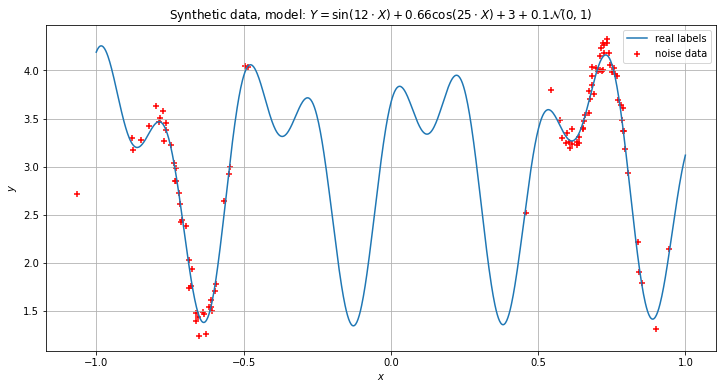

In [27]:
model_name = r'$Y = \sin(12 \cdot X) + 0.66\cos(25 \cdot X) + 3 + 0.1 \mathcal{N}(0, 1)$'
plot_1d_label_data(data_1d[:, 0], range_for_real_labels, real_labels_range, 
                   noise_labels[:, 0], model_name, figsize = (12, 6))

In [28]:
k = gpflow.kernels.Matern52(1, lengthscales=0.3)
m = gpflow.models.GPR(data=(data_1d, noise_labels), kernel=k, mean_function=None)
m.likelihood.variance.assign(0.01)
m.kernel.lengthscales.assign(0.3)

<tf.Variable 'UnreadVariable' shape=() dtype=float64, numpy=-1.0502256128148466>

In [0]:
opt = gpflow.optimizers.Scipy()

In [0]:
opt_logs = opt.minimize(m.training_loss, m.trainable_variables, options=dict(maxiter=100))

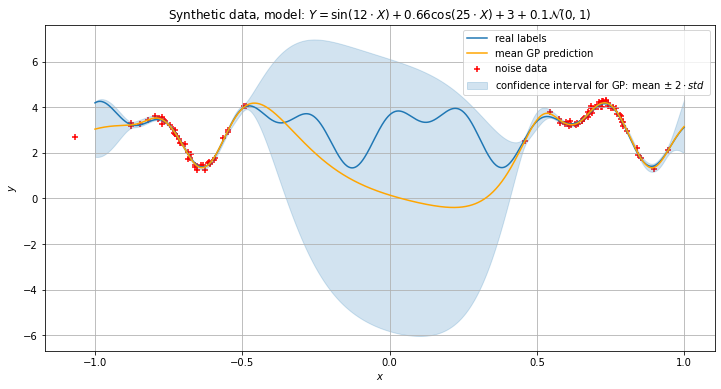

In [31]:
## predict mean and variance of latent GP at test points
xx = np.asarray(range_for_real_labels.reshape(1000, 1).numpy(), 
                dtype = 'float64')
#xx = np.linspace(-0.1, 1.1, 100).reshape(100, 1)
mean, var = m.predict_f(xx)

plot_1d_label_data(data = data_1d[:, 0], 
                   range_for_real_labels = range_for_real_labels, 
                   real_labels = real_labels_range, 
                   noise_labels = noise_labels[:, 0], 
                   model_name = model_name, figsize = (12, 6),
                   range_for_prediction = xx[:, 0],
                   mean_prediction = mean[:, 0],
                   var_prediction = var[:, 0],
                   model_prediction_name = 'GP')

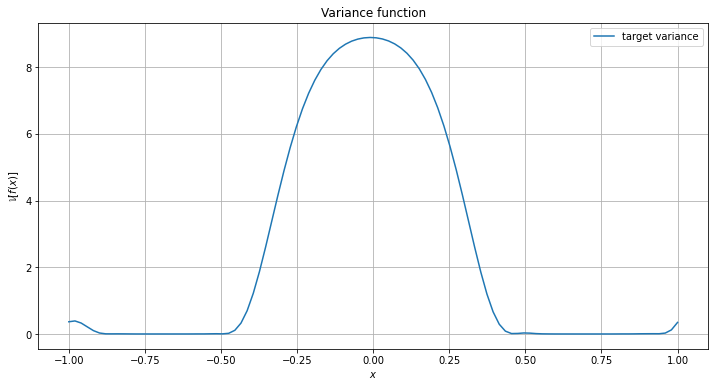

In [32]:
N = 100
grid = np.linspace(-1, 1, num = N).reshape((N, 1))
mean_gp_grid, var_gp_grid = m.predict_f(grid)
plot_variance_and_mean(grid[:, 0], target_variance = var_gp_grid[:, 0])

## Training 1HL BNN 

In [0]:
class HiddenNN(nn.Module):
    def __init__(self, input_size, num_layers, hidden_size, output_size):
        super(HiddenNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.hidden_layers = nn.ModuleList([nn.Linear(hidden_size, hidden_size) 
                                            for i in range(num_layers - 1)])
        self.out = nn.Linear(hidden_size, output_size)
        
    def forward(self, x):
        output = self.fc1(x)
        output = F.relu(output)
        for layer in self.hidden_layers:
            output = layer(output)
            output = F.relu(output)            
        output = self.out(output)
        return output


In [0]:
net = HiddenNN(input_size = 1, num_layers = 1, hidden_size = 50, output_size = 1)

In [0]:
output = net(torch.Tensor(grid))

In [0]:
def model(x_data, y_data):
    
    fc1w_prior = Normal(loc=torch.zeros_like(net.fc1.weight), scale=torch.ones_like(net.fc1.weight))
    fc1b_prior = Normal(loc=torch.zeros_like(net.fc1.bias), scale=torch.ones_like(net.fc1.bias))
    
    outw_prior = Normal(loc=torch.zeros_like(net.out.weight), scale=torch.ones_like(net.out.weight))
    outb_prior = Normal(loc=torch.zeros_like(net.out.bias), scale=torch.ones_like(net.out.bias))
    
    priors = {'fc1.weight': fc1w_prior, 'fc1.bias': fc1b_prior,  
              'out.weight': outw_prior, 'out.bias': outb_prior}
    
    # lift module parameters to random variables sampled from the priors
    lifted_module = pyro.random_module("module", net, priors)
    # sample a regressor (which also samples w and b)
    lifted_reg_model = lifted_module()
    
    lhat = log_softmax(lifted_reg_model(x_data))
    
    pyro.sample("obs", Categorical(logits=lhat), obs=y_data)

In [0]:
def guide(x_data, y_data):
    
    # First layer weight distribution priors
    fc1w_mu = torch.randn_like(net.fc1.weight)
    fc1w_sigma = torch.randn_like(net.fc1.weight)
    fc1w_mu_param = pyro.param("fc1w_mu", fc1w_mu)
    fc1w_sigma_param = softplus(pyro.param("fc1w_sigma", fc1w_sigma))
    fc1w_prior = Normal(loc=fc1w_mu_param, scale=fc1w_sigma_param)
    # First layer bias distribution priors
    fc1b_mu = torch.randn_like(net.fc1.bias)
    fc1b_sigma = torch.randn_like(net.fc1.bias)
    fc1b_mu_param = pyro.param("fc1b_mu", fc1b_mu)
    fc1b_sigma_param = softplus(pyro.param("fc1b_sigma", fc1b_sigma))
    fc1b_prior = Normal(loc=fc1b_mu_param, scale=fc1b_sigma_param)
    # Output layer weight distribution priors
    outw_mu = torch.randn_like(net.out.weight)
    outw_sigma = torch.randn_like(net.out.weight)
    outw_mu_param = pyro.param("outw_mu", outw_mu)
    outw_sigma_param = softplus(pyro.param("outw_sigma", outw_sigma))
    outw_prior = Normal(loc=outw_mu_param, scale=outw_sigma_param).independent(1)
    # Output layer bias distribution priors
    outb_mu = torch.randn_like(net.out.bias)
    outb_sigma = torch.randn_like(net.out.bias)
    outb_mu_param = pyro.param("outb_mu", outb_mu)
    outb_sigma_param = softplus(pyro.param("outb_sigma", outb_sigma))
    outb_prior = Normal(loc=outb_mu_param, scale=outb_sigma_param)
    priors = {'fc1.weight': fc1w_prior, 'fc1.bias': fc1b_prior, 'out.weight': outw_prior, 'out.bias': outb_prior}
    
    lifted_module = pyro.random_module("module", net, priors)
    
    return lifted_module()